In [25]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) already exists in sys.path


In [31]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from data_loading import DataPreprocessor
from random_forest_classifier_2a import plot_predicted_vs_actual

In [27]:
data_loader = DataPreprocessor()
train_df, pred_df = data_loader.load_and_preprocess_data("1d", 0.25, 1, do_bucketing=False, apply_train_val_split=False)

Removed 64 outliers from 1268 observations. Percentage: 5.05%


In [28]:
test_predictions = []
test_actuals = []
final_predictions = []
user_ids = []

# For each user
for id in train_df["id"].unique():
    train_group = train_df[train_df["id"] == id]

    # Keep date column for evaluation
    dates = train_group['date']

    # Then drop id, mood, and date for features
    features = train_group.drop(columns=['id', 'mood', 'date'])
    labels = train_group['mood']
    X_train, X_test, y_train, y_test, dates_train, dates_val = train_test_split(
        features, labels, dates, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_test_pred = model.predict(X_test)
    test_predictions.extend(y_test_pred)
    test_actuals.extend(y_test)

    # Predict on the prediction set
    pred_group = pred_df[pred_df["id"] == id]
    X_pred = pred_group.drop(columns=["id", "date", "mood"])
    y_pred = model.predict(X_pred)

    final_predictions.append(y_pred[0])
    user_ids.append(id)


Validation Statistics
MAE: 0.4709005376344086
MSE: 0.40578997939068123
R²: 0.12835349610665892


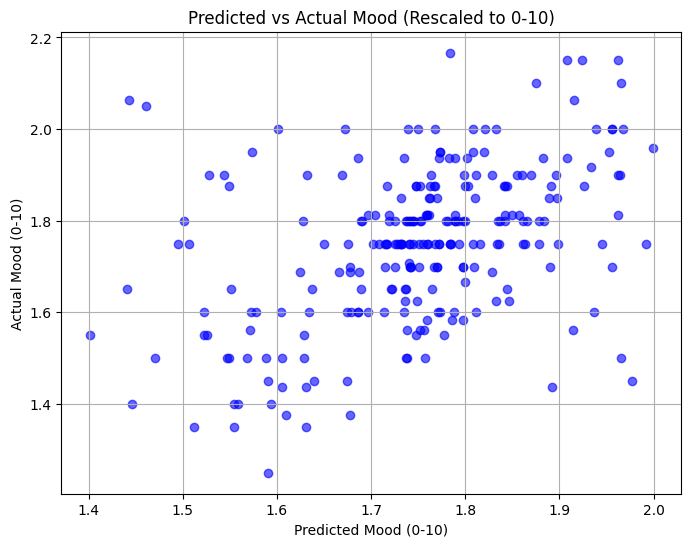

In [32]:
# Evaluate across all users
print("Validation Statistics")
print("MAE:", mean_absolute_error(test_actuals, test_predictions))
print("MSE:", mean_squared_error(test_actuals, test_predictions))
print("R²:", r2_score(test_actuals, test_predictions))
plot_predicted_vs_actual(np.array(test_actuals), np.array(test_predictions))

In [ ]:
# Optional: view predictions
results_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_next_day_mood": final_predictions,
})
print(results_df)